In [1]:
pip install pygam



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import required Python packages.

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

# Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

file_path = 'E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv'

## Simple Linear Regression
### The Regression Equation

kc_real_estate = pd.read_csv(file_path, sep='\t')
kc_real_estate.head()
kc_real_estate.columns


Index(['id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15'], dtype='object')

In [4]:
import pandas as pd

file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"

# Subset the features of interest
subset = ['price', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']

# Read in the data
kc_real_estate = pd.read_csv(file_path)

# Print the head of the data frame
print(kc_real_estate[subset].head())


      price  sqft_living  sqft_lot  bathrooms  bedrooms          grade
0  221900.0         1180      5650       1.00         3      7 Average
1  538000.0         2570      7242       2.25         3      7 Average
2  180000.0          770     10000       1.00         2  6 Low Average
3  604000.0         1960      5000       3.00         4      7 Average
4  510000.0         1680      8080       2.00         3         8 Good


In [5]:
### Fitted Values and Residuals
# The method `predict` of a fitted _scikit-learn_ model can be used to predict new data points.
## Multiple linear regression

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"

# Subset the features of interest
subset = ['price', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']

# Read in the data
kc_real_estate = pd.read_csv(file_path, usecols=subset)

# Convert grade column to numeric using label encoding
label_encoder = LabelEncoder()
kc_real_estate['grade'] = label_encoder.fit_transform(kc_real_estate['grade'])

# Define the predictors and outcome
predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
outcome = 'price'

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
kc_real_estate[predictors] = imputer.fit_transform(kc_real_estate[predictors])

# Fit the linear regression model
house_lm = LinearRegression()
house_lm.fit(kc_real_estate[predictors], kc_real_estate[outcome])

# Print the model coefficients
print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')



Intercept: 274851.001
Coefficients:
 sqft_living: 285.280631886674
 sqft_lot: -0.4054973153180579
 bathrooms: 15073.10706225794
 bedrooms: -50472.29505024979
 grade: -23455.8909890381


In [6]:
### Assessing the Model
# _Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score`.

fitted = house_lm.predict(kc_real_estate[predictors])
RMSE = np.sqrt(mean_squared_error(kc_real_estate[outcome], fitted))
r2 = r2_score(kc_real_estate[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

# While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

model = sm.OLS(kc_real_estate[outcome], kc_real_estate[predictors].assign(const=1))
results = model.fit()
print(results.summary())

RMSE: 252500
r2: 0.5276
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     4822.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        08:49:07   Log-Likelihood:            -2.9929e+05
No. Observations:               21597   AIC:                         5.986e+05
Df Residuals:                   21591   BIC:                         5.986e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   285.2806    

Coefficients: [ 2.72209002e+02 -3.86075496e-01 -3.61750991e+03 -4.60835292e+04
  3.46799593e+04]
Intercept: 87038.4061901223
R-squared: 0.5262588762956726
Coefficients: [ 0.00000000e+00  1.29186171e+02  6.90762628e-01 -7.62812044e+04
 -2.60621857e+03 -3.25155499e+04  4.03223166e-02 -7.06900187e-04
 -2.73319499e+01 -1.48238028e+01  8.01980650e+00  8.41900771e-07
  5.34931924e-01 -2.15820190e-01 -7.63808145e-02  2.48123312e+04
 -1.26434783e+03  2.24177478e+04  1.39319041e+03  1.21102656e+03
 -6.06581129e+02]
Intercept: 278585.3322778331
R-squared: 0.5844587321314108


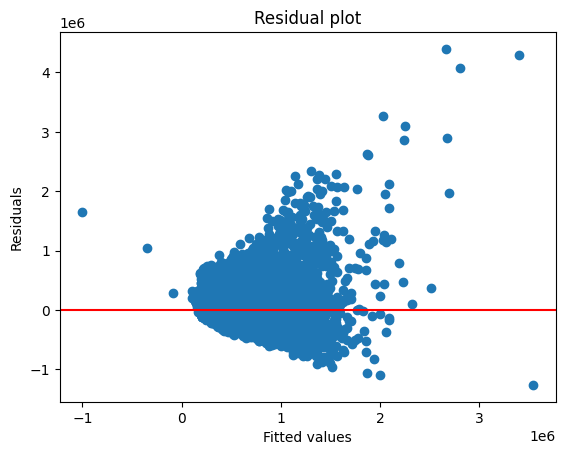

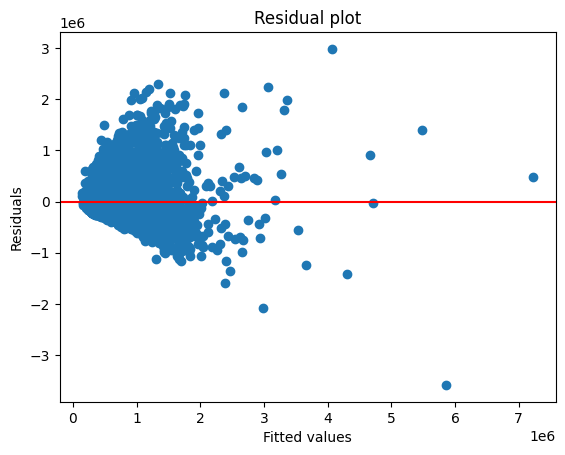

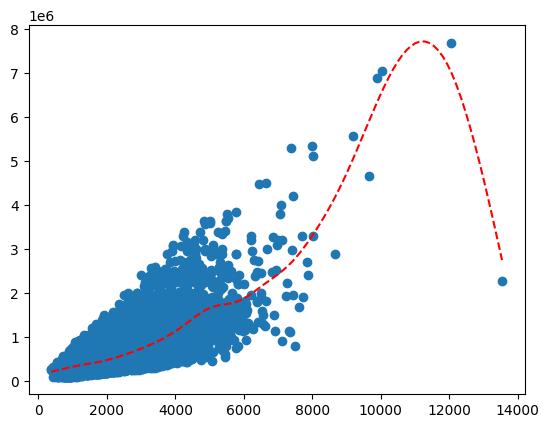

In [7]:
### Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s, f

### Load Data
file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)

### Convert grade column to numeric values
kc_real_estate['grade'], _ = pd.factorize(kc_real_estate['grade'])

### Multiple Linear Regression
subset = ['price', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
kc_real_estate_subset = kc_real_estate[subset]
X = kc_real_estate_subset.drop('price', axis=1)
y = kc_real_estate_subset['price']

model = linear_model.LinearRegression()
model.fit(X, y)

print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')
print(f'R-squared: {model.score(X, y)}')

### Polynomial Regression
degree = 2
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

model_poly = linear_model.LinearRegression()
model_poly.fit(X_poly, y)

print(f'Coefficients: {model_poly.coef_}')
print(f'Intercept: {model_poly.intercept_}')
print(f'R-squared: {model_poly.score(X_poly, y)}')

### Fitted Values and Residuals
# The method `predict` of a fitted _scikit-learn_ model can be used to predict new data points.

## Multiple linear regression
fitted = model.predict(X)
residuals = y - fitted

plt.scatter(fitted, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.axhline(y=0, color='red', linestyle='-')
plt.show()

## Polynomial regression
fitted_poly = model_poly.predict(X_poly)
residuals_poly = y - fitted_poly

plt.scatter(fitted_poly, residuals_poly)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.axhline(y=0, color='red', linestyle='-')
plt.show()

### Generalized Additive Models (GAMs)
# `pyGAM` is a Python module for building and analyzing generalized additive models (GAMs).

## GAM for a single variable
X_gam = kc_real_estate[['sqft_living']]
y_gam = kc_real_estate['price']

gam = LinearGAM(s(0)).fit(X_gam, y_gam)

XX = gam.generate_X_grid(term=0)
plt.plot(XX, gam.predict(XX), 'r--')
plt.scatter(X_gam, y_gam)
plt.show()

## GAM for multiple variables
X_gam = kc_real_estate[['sqft_living', 'grade', 'sqft_above']]
y_gam = kc_real_estate['price']

gam = LinearGAM(s(0) + s(1) + s(2)).fit(X_gam, y_gam)




In [8]:
### Model Selection and Stepwise Regression
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Define outcome and predictors
outcome = "price"
predictors = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15"]

# Load data and create dummy variables
file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)

X = pd.get_dummies(kc_real_estate[predictors], drop_first=True)
X['condition_1'] = [1 if nc else 0 for nc in kc_real_estate['condition'] == 1]

# Check for infinite or missing values in X
if np.any(np.isinf(X)) or np.any(np.isnan(X)):
    # Replace infinite or missing values with a suitable value
    X = np.nan_to_num(X, nan=0, posinf=1e10, neginf=-1e10)

X = pd.DataFrame(X)  # Convert X to a DataFrame
X = X.assign(const=1)

kc_real_estate_full = sm.OLS(kc_real_estate[outcome], X)
results = kc_real_estate_full.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     198.8
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        08:49:09   Log-Likelihood:            -2.9207e+05
No. Observations:               21597   AIC:                         5.848e+05
Df Residuals:                   21261   BIC:                         5.875e+05
Df Model:                         335                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0           -1.76e+04   1783.389     -9.869      0.0

In [9]:
# We can use the `stepwise_selection` method from the _dmba_ package.

import pandas as pd
from sklearn.linear_model import LinearRegression
from dmba import AIC_score, stepwise_selection
from sklearn.impute import SimpleImputer

file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)

# define the outcome variable
outcome = 'price'

# define the feature variables
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 
            'sqft_living15', 'sqft_lot15']

# split the data into training and validation sets
train_data = kc_real_estate.sample(frac=0.7, random_state=1)
valid_data = kc_real_estate.drop(train_data.index)

# define the X and y variables for the training data
X_train = train_data[features]
y_train = train_data[outcome]

# remove rows with missing values
train_data = train_data.dropna()

# identify non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(exclude=['float', 'int']).columns

# drop non-numeric columns from X_train
X_train = X_train.drop(non_numeric_cols, axis=1)

# impute missing values using the median
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)

# convert the imputed data back to a pandas DataFrame
X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)


# define the train_model() and score_model() functions
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train.loc[:, variables], y_train)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    return AIC_score(y_train, model.predict(X_train.loc[:, variables]), model)

# run stepwise selection on the updated X_train
best_model, best_variables = stepwise_selection(X_train.columns.map(str), train_model, score_model, 
                                                verbose=True)

# print results
print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')


Variables: bedrooms, bathrooms, sqft_living, sqft_lot, floors, sqft_above, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15
Start: score=430930.55, constant
Step: score=420216.27, add sqft_living
Step: score=417901.36, add lat
Step: score=417261.18, add yr_built
Step: score=416774.81, add bedrooms
Step: score=416496.09, add bathrooms
Step: score=416201.31, add sqft_living15
Step: score=415946.47, add long
Step: score=415792.25, add zipcode
Step: score=415712.26, add floors
Step: score=415655.92, add yr_renovated
Step: score=415648.25, add sqft_above
Step: score=415642.07, add sqft_lot15
Step: score=415635.55, add sqft_lot
Step: score=415635.55, unchanged None

Intercept: -9410370.080
Coefficients:
 sqft_living: 246.81593104240503
 lat: 623495.1967544059
 yr_built: -2420.7203517318853
 bedrooms: -63629.72359724671
 bathrooms: 58214.10675107465
 sqft_living15: 81.97617569283466
 long: -340886.4485795354
 zipcode: -583.7343093427364
 floors: 28338.13734220827
 yr_reno

     predictor       house_lm       house_wt
0  sqft_living     285.280632     284.962442
1     sqft_lot      -0.405497      -0.397142
2    bathrooms   15073.107062   15195.121641
3     bedrooms  -50472.295050  -50459.823430
4        grade  -23455.890989  -23564.872599
5    intercept  274851.001144  276398.563243
   abs_residual_lm  abs_residual_wt  Year
0     63300.180937     63807.064836  2014
1    161936.091362    162166.511995  2014
2     60399.394582     61169.592942  2015
3    116343.433862    115833.668202  2014
4     91527.645522     91146.519422  2015
2014 166444.09875818624 166503.95130321538
2015 174131.65009753738 174153.59207683755


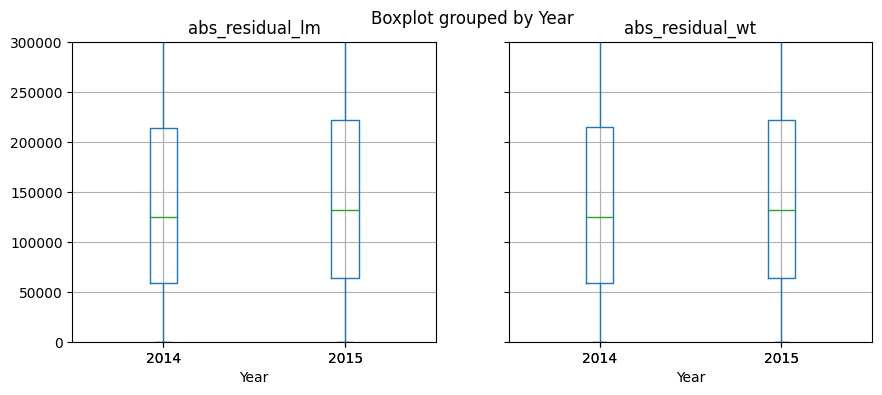

In [10]:
### Weighted regression
# We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from dmba import AIC_score, stepwise_selection



file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)

kc_real_estate['Year'] = [int(date.split('/')[2]) for date in kc_real_estate.date]
kc_real_estate['Weight'] = kc_real_estate.Year - 2005

predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
outcome = 'price'

# Convert grade column to numeric using label encoding
label_encoder = LabelEncoder()
kc_real_estate['grade'] = label_encoder.fit_transform(kc_real_estate['grade'])

house_lm = LinearRegression()
house_lm.fit(kc_real_estate[predictors], kc_real_estate[outcome])

house_wt = LinearRegression()
house_wt.fit(kc_real_estate[predictors], kc_real_estate[outcome], sample_weight=kc_real_estate.Weight)

# Retrieve coefficients from the weighted model
coefficients = list(house_wt.coef_)

# Add intercept to the coefficients list
coefficients.append(house_wt.intercept_)

# Create a DataFrame with the coefficients for both models
coef_df = pd.DataFrame({
    'predictor': predictors + ['intercept'],
    'house_lm': list(house_lm.coef_) + [house_lm.intercept_],
    'house_wt': coefficients
})

print(coef_df)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(kc_real_estate[predictors]) - kc_real_estate[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(kc_real_estate[predictors]) - kc_real_estate[outcome]),
    'Year': kc_real_estate['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))


In [11]:
## Factor variables in regression
### Dummy Variables Representation

print(kc_real_estate.view.head())

print(pd.get_dummies(kc_real_estate['view']).head(6))

print(pd.get_dummies(kc_real_estate['view'], drop_first=True).head(6))

predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms',
              'grade', 'view']

X = pd.get_dummies(kc_real_estate[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, kc_real_estate[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

0    NONE
1    NONE
2    NONE
3    NONE
4    NONE
Name: view, dtype: object
   AVERAGE  EXCELLENT  FAIR  GOOD  NONE
0        0          0     0     0     1
1        0          0     0     0     1
2        0          0     0     0     1
3        0          0     0     0     1
4        0          0     0     0     1
5        0          0     0     0     1
   EXCELLENT  FAIR  GOOD  NONE
0          0     0     0     1
1          0     0     0     1
2          0     0     0     1
3          0     0     0     1
4          0     0     0     1
5          0     0     0     1
Intercept: 378226.081
Coefficients:
 sqft_living: 255.63072331393585
 sqft_lot: -0.4014333139179129
 bathrooms: 18985.347814333567
 bedrooms: -40660.558462767855
 grade: -21921.656452096777
 view_EXCELLENT: 452114.862625939
 view_FAIR: 48255.912328230814
 view_GOOD: 83289.88504453674
 view_NONE: -116166.87738302964


In [12]:
### Factor Variables with many levels

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)

print(pd.DataFrame(kc_real_estate['zipcode'].value_counts()).transpose())

kc_real_estate = kc_real_estate.copy()

predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
outcome = 'price'

# Convert grade column to numeric using label encoding
label_encoder = LabelEncoder()
kc_real_estate['grade'] = label_encoder.fit_transform(kc_real_estate['grade'])


house_lm = LinearRegression()
house_lm.fit(kc_real_estate[predictors], kc_real_estate[outcome])

zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'zipcode': kc_real_estate['zipcode'],
        'residual' : kc_real_estate[outcome] - house_lm.predict(kc_real_estate[predictors]),
    })
    .groupby(['zipcode'])
    .apply(lambda x: {
        'zipcode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')

zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['zipgroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()

print(zip_groups.zipgroup.value_counts().sort_index())

to_join = zip_groups[['zipcode', 'zipgroup']].set_index('zipcode')
house = kc_real_estate.join(to_join, on='zipcode', rsuffix='_r')
house['zipgroup'] = house['zipgroup'].astype('category')


         98103  98038  98115  98052  98117  98042  98034  98118  98023  98006  \
zipcode    602    589    583    574    553    547    545    507    499    498   

         ...  98188  98032  98014  98070  98109  98102  98010  98024  98148  \
zipcode  ...    136    125    124    117    109    104    100     80     57   

         98039  
zipcode     50  

[1 rows x 70 columns]
0    14
1    14
2    14
3    14
4    14
Name: zipgroup, dtype: int64


In [13]:
house.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'zipgroup'],
      dtype='object')

In [14]:
predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade', 'view', 'yr_built']
outcome = 'price'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')


Intercept: 5258582.358
Coefficients:
 sqft_living: 254.5026312025127
 sqft_lot: -0.36331302106668906
 bathrooms: 80145.02362460099
 bedrooms: -52315.07246533366
 grade: -19750.86660125019
 yr_built: -2544.3734008014562
 view_EXCELLENT: 436302.27932598407
 view_FAIR: 45686.68566000965
 view_GOOD: 75713.3780166782
 view_NONE: -83089.04402030418


In [15]:
## Interpreting the Regression Equation

### Correlated predictors

# The results from the stepwise regression are.
### Correlated predictors


import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load the data
file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)

# Convert "grade" column to numerical using label encoding
le = LabelEncoder()
kc_real_estate['grade'] = le.fit_transform(kc_real_estate['grade'])

# Select the predictors and outcome variable
predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
outcome = 'price'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(house[predictors], house[outcome], test_size=0.3, random_state=42)

# Fit the model on the training data
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [16]:
# Use stepwise selection to identify the best variables
# Define the stepwise selection function
def stepwise_selection(X, y, 
                        initial_list=[], 
                        threshold_in=0.01, 
                        threshold_out=0.05, 
                        verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='object')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval}')
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # backward step
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval}')
        if not changed:
            break
    return included, excluded

# Perform stepwise selection on the training data
best_variables, excluded_variables = stepwise_selection(X_train, y_train, verbose=False)

# Fit the model on the training data using the best variables
model = sm.OLS(y_train, sm.add_constant(X_train[best_variables])).fit()

# Predict on the testing data
y_pred = model.predict(sm.add_constant(X_test[best_variables]))

# Compute the mean squared error
mse = ((y_pred - y_test)**2).mean()
print(f"est MSE: {mse:.2f}")


TypeError: reduction operation 'argmin' not allowed for this dtype

In [ ]:
### Confounding variables

predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms',
              'grade', 'view', 'zipgroup']
outcome = 'price'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

### Interactions and Main Effects

model = smf.ols(formula='price ~  sqft_living*zipgroup + sqft_lot + ' +
     'bathrooms + bedrooms + grade + view', data=house)
results = model.fit()
print(results.summary())

Intercept: 99893.757
Coefficients:
 sqft_living: 235.46049947571197
 sqft_lot: 0.11557142738711512
 bathrooms: 18432.372058328703
 bedrooms: -26045.97863279324
 grade: -20356.398764238562
 zipgroup: 107963.87131369092
 view_EXCELLENT: 463433.3407642568
 view_FAIR: 24187.153118502567
 view_GOOD: 82495.02541993294
 view_NONE: -76482.47002287816
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     6846.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        08:45:06   Log-Likelihood:            -2.9023e+05
No. Observations:               21534   AIC:                         5.805e+05
Df Residuals:                   21522   BIC:                         5.806e+05
Df Model:              

In [18]:
## Testing the Assumptions: Regression Diagnostics
### Outliers

# The _statsmodels_ package has the most developed support for outlier analysis.

house_98105 = house.loc[house['zipcode'] == 98105, ]

predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
outcome = 'price'


house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     234.0
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.36e-86
Time:                        08:51:53   Log-Likelihood:                -3109.3
No. Observations:                 229   AIC:                             6231.
Df Residuals:                     223   BIC:                             6251.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   293.1390     26.451     11.082      

In [19]:
# The `OLSInfluence` class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals.

from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

print(result_98105.resid.loc[sresiduals.idxmin()])

outlier = house_98105.loc[sresiduals.idxmin(), :]
print('price', outlier[outcome])
print(outlier[predictors])

8464 -2.807806639992594
-529855.3984735797
price 515000.0
sqft_living    1710
sqft_lot       9448
bathrooms      2.75
bedrooms          3
grade             8
Name: 8464, dtype: object


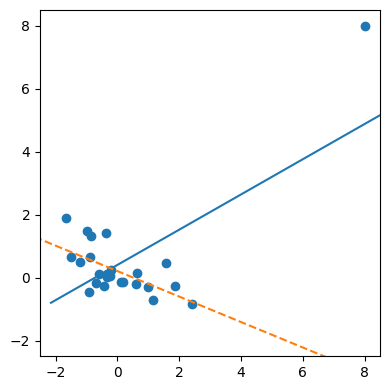

In [20]:
### Influential values

from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()


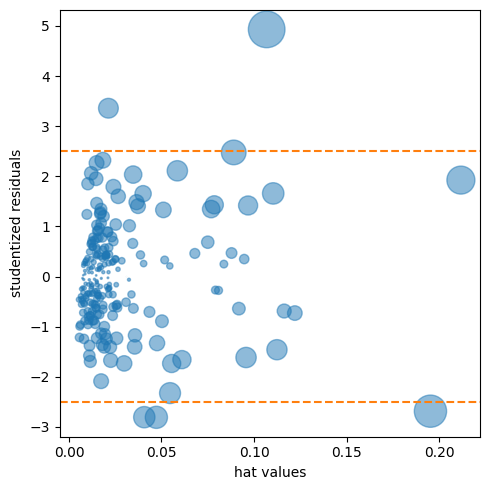

,Original,Influential removed
sqft_living,293.139036,313.898524
sqft_lot,57.193971,51.072220
bathrooms,66063.278984,31298.698356
bedrooms,-42581.140858,-42823.501451
grade,-3602.463220,1541.914018
const,-21891.885277,-7414.955790


In [21]:
# The package _statsmodel_ provides a number of plots to analyze the data point influence

influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

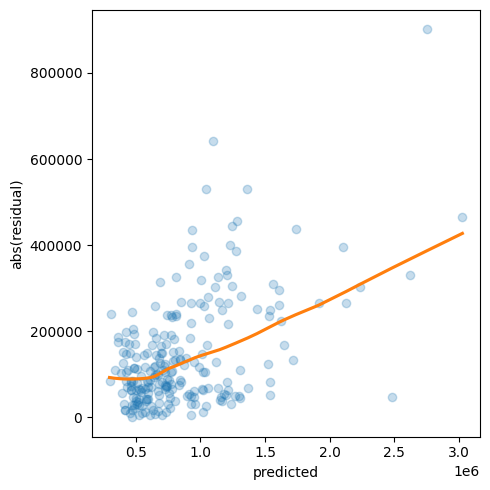

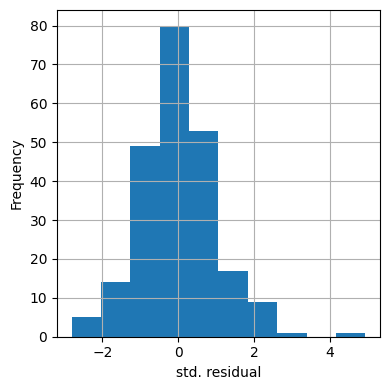

In [22]:
### Heteroskedasticity, Non-Normality and Correlated Errors

# The `regplot` in _seaborn_ allows adding a lowess smoothing line to the scatterplot.

fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

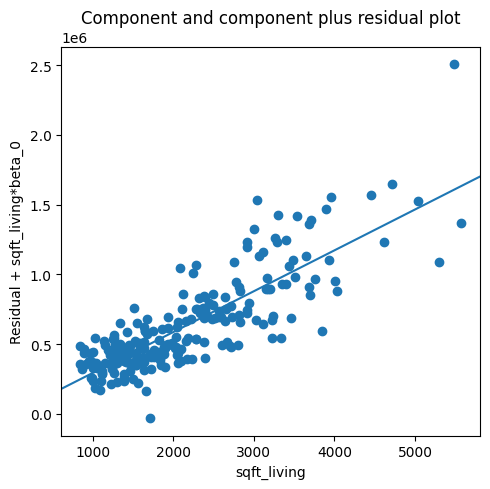

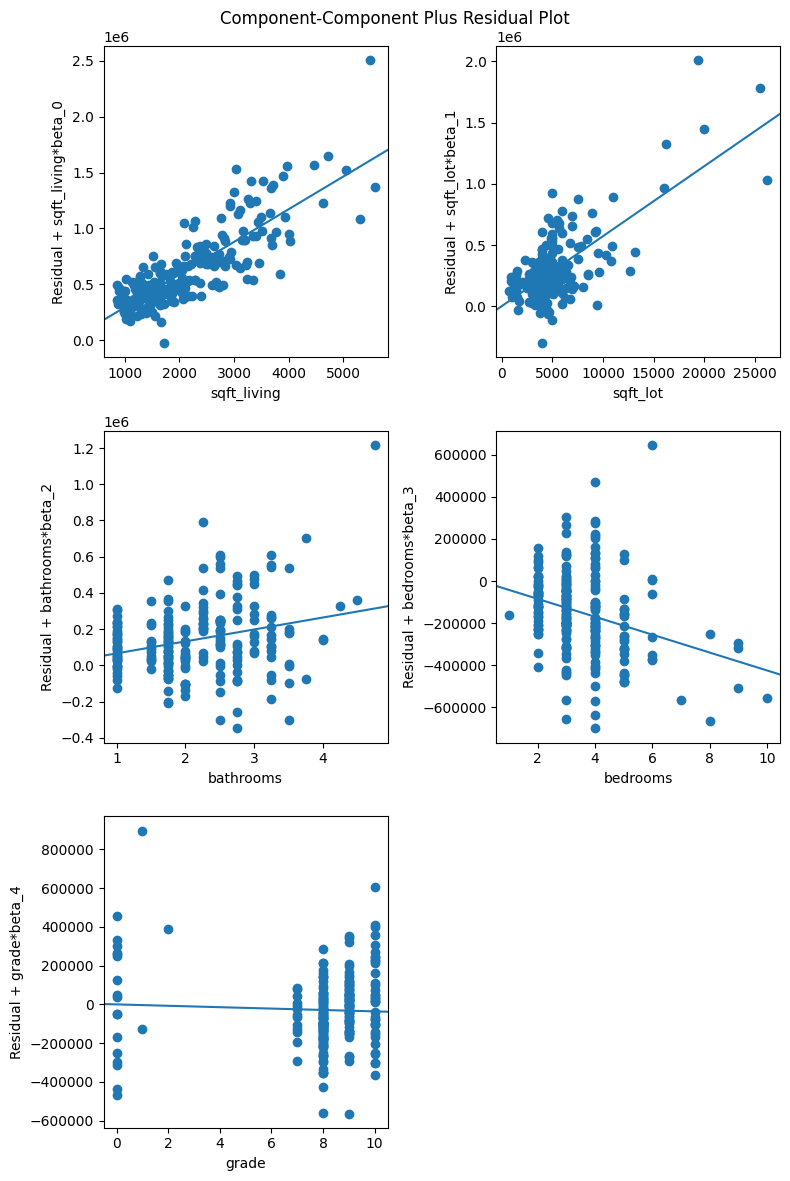

In [24]:
### Partial Residual Plots and Nonlinearity

fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'sqft_living', ax=ax)

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

In [26]:
### Polynomial and Spline Regression

model_poly = smf.ols(formula='price ~  sqft_living + np.power(sqft_living, 2) + ' + 
                'sqft_lot + bathrooms + bedrooms + grade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     199.5
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           1.73e-86
Time:                        08:56:07   Log-Likelihood:                -3106.7
No. Observations:                 229   AIC:                             6227.
Df Residuals:                     222   BIC:                             6251.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

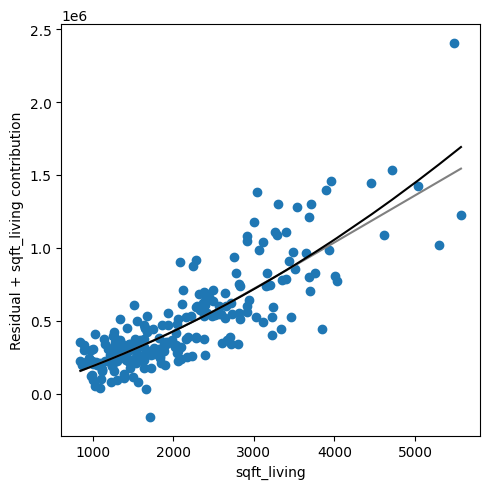

0.025264113053380787


In [27]:
# The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'price', 'sqft_living', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     120.7
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           4.62e-83
Time:                        08:58:44   Log-Likelihood:                -3104.1
No. Observations:                 229   AIC:                             6230.
Df Residuals:                     218   BIC:                             6268.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

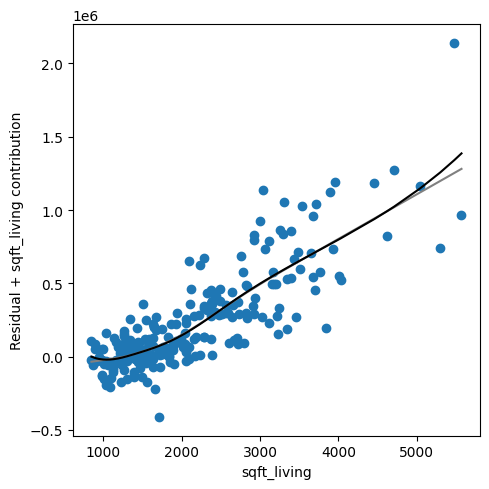

In [28]:
### Splines

formula = ('price ~ bs(sqft_living, df=6, degree=3) + ' + 
           'sqft_lot + bathrooms + bedrooms + grade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'price', 'sqft_living', ax)

plt.tight_layout()
plt.show()


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:  00:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
C:\Users\susan\AppData\Local\Temp\ipykernel_3484\512863066.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6973
Link Function:                     IdentityLink Log Likelihood:                                 -5778.6157
Number of Samples:                          229 AIC:                                             11574.626
                                                AICc:                                           11575.3951
                                                GCV:                                      38634157991.7134
                                                Scale:                                    36303924243.5995
                                                Pseudo R-Squared:                                   0.8457
Feature Function                  Lam

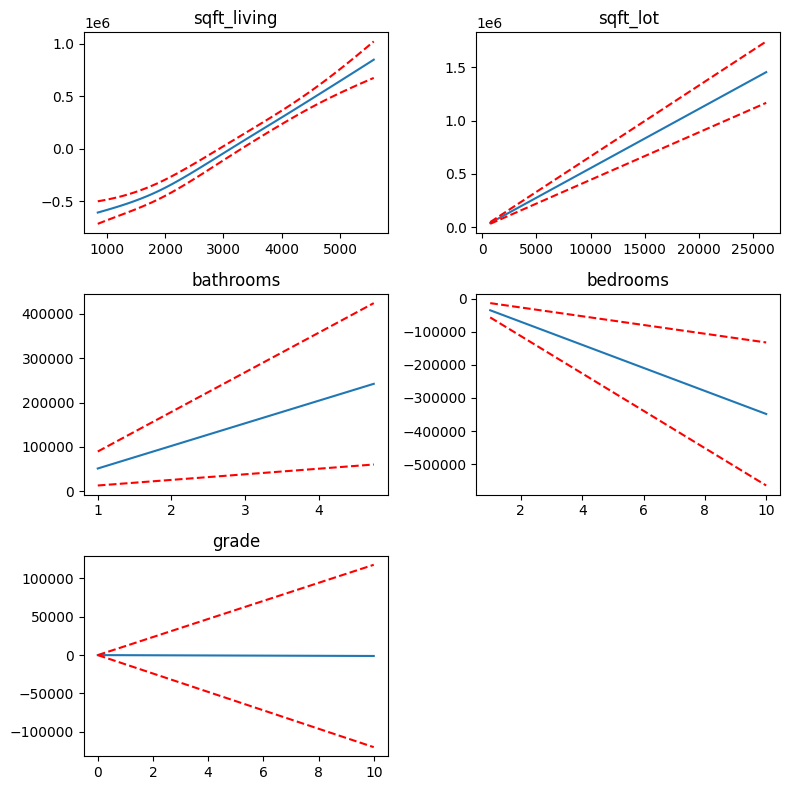

In [29]:
### Generalized Additive Models

predictors = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
outcome = 'price'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

In [30]:
## Regularization
### Lasso

from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

subset = ['price', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']

file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)
print(house[subset].head())

predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 
            'sqft_living15', 'sqft_lot15']

outcome = 'price'

X = pd.get_dummies(house[predictors], drop_first=True)
X['condition'] = [1 if nc else 0 for nc in X['condition']]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

      price  sqft_living  sqft_lot  bathrooms  bedrooms  grade
0  221900.0         1180      5650       1.00         3      8
1  538000.0         2570      7242       2.25         3      8
2  180000.0          770     10000       1.00         2      7
3  604000.0         1960      5000       3.00         4      8
4  510000.0         1680      8080       2.00         3      9


KeyError: 'condition'

      price  sqft_living  sqft_lot  bathrooms  bedrooms          grade
0  221900.0         1180      5650       1.00         3      7 Average
1  538000.0         2570      7242       2.25         3      7 Average
2  180000.0          770     10000       1.00         2  6 Low Average
3  604000.0         1960      5000       3.00         4      7 Average
4  510000.0         1680      8080       2.00         3         8 Good
LinearRegression()
Lasso(alpha=10)


c:\Users\susan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+14, tolerance: 2.915e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\susan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.527e+14, tolerance: 2.915e+11
  model = cd_fast.enet_coordinate_descent(
c:\Users\susan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

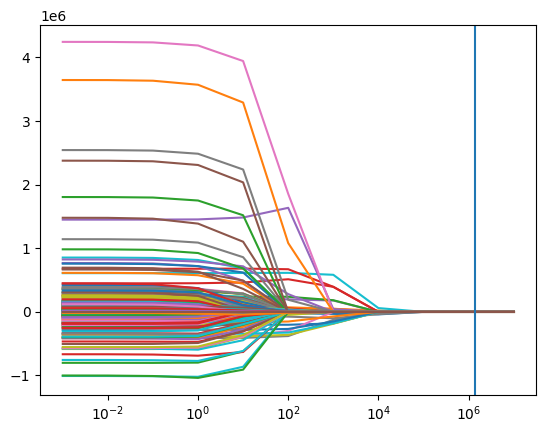

,name,coef
0,bedrooms,-0.000000
1,bathrooms,0.000000
2,sqft_living,246.070945
3,sqft_lot,0.068290
4,floors,0.000000
...,...,...
331,sqft_basement_970.0,-0.000000
332,sqft_basement_980.0,0.000000
333,sqft_basement_990.0,-0.000000
334,sqft_basement_?,-0.000000


In [32]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

subset = ['price', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade']

file_path = "E:\Data Science Phase 2\phase-2-project\data\kc_house_data.csv"
kc_real_estate = pd.read_csv(file_path)
print(kc_real_estate[subset].head())

predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
            'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
            'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 
            'sqft_living15', 'sqft_lot15']

outcome = 'price'

X = pd.get_dummies(kc_real_estate[predictors], drop_first=True)
X['condition'] = [1 if nc else 0 for nc in kc_real_estate['condition']]
columns = X.columns

# Fill missing values with the mean of the corresponding column
X = X.fillna(X.mean())
y = kc_real_estate[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})


In [33]:

# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308